In [429]:
import psycopg2 as ps
import pandas as pd
from collections import Counter
import spacy
from spacy.tokenizer import Tokenizer
import matplotlib.pyplot as plt
import numpy as np
import re

# Import Raw Data to Database

Raw data is supplied as a csv file. Use the following SQL commands to define a schema for the data and load the data from the csv file to the database. The example below creates a schema and loads news from February into the Postgres DB.

CREATE TABLE FebNews ( news text, src text, title text NOT NULL, collectiondate date, publishdate date, url text, author text[], keywords text[] );

COPY FebNews(news, src, title, collectiondate, publishdate, url, author, keywords) FROM '/path/to/file/news-*-01.csv' DELIMITER ',' CSV HEADER;

# Query Database and Collect News Text (Subsample Workflow)

Connect to database

In [430]:
# connect to postgres database
conn = ps.connect(dbname = 'SQLBook', user = 'postgres', password = '', port = 5436)

# initialize cursor
cur = conn.cursor()

# Filtering News Articles By Length

News articles to be filtered by length as blocking strategy. Visualize with histogram of character counts for news articles

Text(0.5,1,'Histogram of News Article Lengths')

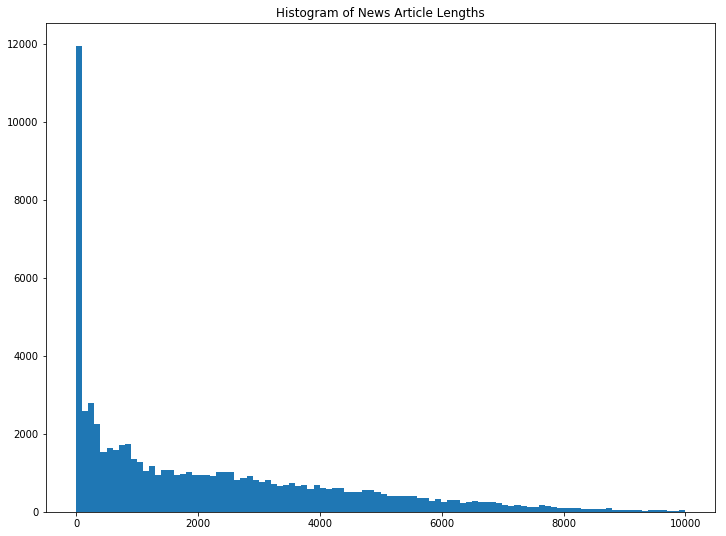

In [431]:
# look at distrubution of news articles by character length
cur.execute("SELECT LENGTH(news) FROM FebNews")
chars = cur.fetchall()

chars = np.array([x[0] for x in chars])
chars = chars[chars < 10000]

fig = plt.figure(figsize = (12,9))

bins = 100
x, y, z = plt.hist(chars, bins = bins)
plt.title('Histogram of News Article Lengths')

Text(0.5,1,'February News Article Character Counts')

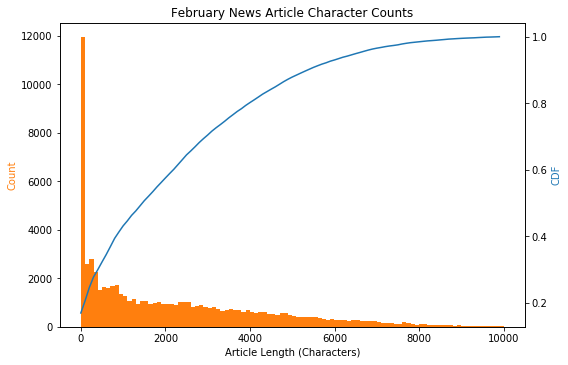

In [432]:
fig, ax1 = plt.subplots(figsize = (8,5))

color = 'tab:orange'
ax1.set_xlabel('Article Length (Characters)')
ax1.set_ylabel('Count', color = color)
ax1.hist(chars, bins = bins, color = color)
ax1.tick_params(axis = 'y', labelcolor = 'k')

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('CDF', color = color)
ax2.plot(y[0:bins], np.cumsum(x)/sum(x), color = color)
ax2.tick_params(axis = 'CDF', labelcolor = color)

fig.tight_layout() 
plt.title('February News Article Character Counts')

We will set the threshold to 300 characters as this will reduce the amount of data to be processed. Articles under 300 charachters are generally lower quality than longer ones, tending to be one or two sentences.

ex: ' The smart socks that every runner needs '

In [433]:
# look at distrubution of news articles by character length
cur.execute("SELECT COUNT(LENGTH(news)) FROM FebNews")
unfiltered_articles = cur.fetchall()

cur.execute("SELECT COUNT(LENGTH(news)) FROM FebNews WHERE LENGTH(news) > 300")
filtered_articles = cur.fetchall()

reduced_size = filtered_articles[0][0]/unfiltered_articles[0][0]

print('Reduced articles to {}% original number with 300 characther threshold'.format(np.round(reduced_size*100), 1))

Reduced articles to 76.0% original number with 300 characther threshold


For development we only want to query specific dates.

In [434]:
# ISO date query
def date_query(year, month, day):
    return "SELECT title, news, publishdate FROM FebNews WHERE DATE(publishdate) = '{}-{}-{}' AND LENGTH(news) > 300 ".format(year, month, day)

def month_query(year, month, day):
    return "SELECT title, news, publishdate FROM FebNews WHERE LENGTH(news) > 300 ".format(year, month, day)

# run sample date query
query = date_query('2018', '02', '02')

cur.execute(query)
result = cur.fetchall()

# organize
titles = [x[0] for x in result]
articles = [x[1] for x in result]
publishdates = [x[2] for x in result]

# Cleaning Up News Text

Spacy will be used for NLP workflow.

In [435]:
nlp = spacy.load('en_core_web_sm')
tokenizer = Tokenizer(nlp.vocab)

We will remove parts of speech that will likely not be useful for matching news to tweets, i.e. conjunctions, prepositions, pronouns, due to them being non-specific. Test on the first 100 articles.

In [436]:
article_sample = articles[0:100]

processed_articles = []

for article in article_sample:
    article = re.sub(r'[^\w\s]', '', article)
    vocab = []
    doc = nlp(article)
    for token in doc:
        vocab.append(token.lemma_)
    processed_articles.append(vocab)
    
# number of words processed
print('Processed words = ', len([item for sublist in processed_articles for item in sublist]))

Processed words =  52825


In [437]:
# removing stop words
processed_articles = []

for article in article_sample:
    article = re.sub(r'[^\w\s]', '', article)
    vocab = []
    doc = nlp(article)
    for token in doc:
        if token.is_stop == False:
            vocab.append(token.lemma_)
    processed_articles.append(vocab)
    
# number of words processed
print('Processed words = ', len([item for sublist in processed_articles for item in sublist]))

Processed words =  31704


In [438]:
# remove stop words, parts of speech, and apostrophies
processed_articles = []
allowable_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ']

for article in article_sample:
    article = re.sub(r'[^\w\s]', '', article)
    vocab = []
    doc = nlp(article)
    for token in doc:
        if token.is_stop == False and token.pos_ in allowable_pos:
            vocab.append(token.lemma_)
    processed_articles.append(vocab)
    
# number of words processed
print('Processed words = ', len([item for sublist in processed_articles for item in sublist]))

Processed words =  25910


By filtering out stopwords and other parts of the speech the amount of words passed downstream is only ~ 42% of the original amount. Combining this with the fraction of articles filtered out the news article blocking these two preprocessing steps reduce the amount of data being handled to only ~ 30% of the original volume.

Run preprocessing on days worth of data

In [441]:
%%time

# prepare query
query = date_query('2018', '02', '02')

# run query
cur.execute(query)
result = cur.fetchall()

# organize
titles = [x[0] for x in result]
articles = [x[1] for x in result]
publishdates = [x[2] for x in result]

processed_articles = []
allowable_pos = ['NOUN', 'VERB', 'PROPN', 'ADJ']

for article in articles:
    article = re.sub(r'[^\w\s]', '', article)
    vocab = []
    doc = nlp(article)
    for token in doc:
        if token.is_stop == False and token.pos_ in allowable_pos:
            vocab.append(token.lemma_)
    processed_articles.append(vocab)
    

CPU times: user 29min 44s, sys: 4min 58s, total: 34min 43s
Wall time: 20min 40s


Save news from one day to csv for development.

In [443]:
processed_titles = []
processed_text = []

for title, article in zip(titles, processed_articles):
    processed_titles.append(title[0])
    processed_text.append(' '.join(article))
    
df = pd.DataFrame({'Title': titles, 'Text': processed_text})
df.to_csv('feb20180202sample.csv')   

# Save Back to Database

In [ ]:
cur.execute(''' CREATE TABLE FebNewsProcessed (
                    news text,
                    title text NOT NULL,
                    publishdate date); ''')

In [409]:
#cur.execute("select news from FebNews where news ~ '[[:ascii:]]';")
#cur.execute("SELECT count(news) FROM FebNews WHERE news = Cast(news AS VARCHAR)")
cur.execute("SELECT count(news) FROM FebNews WHERE news LIKE '%[^A-z0-9 -!?@#$%^&*.,():;]%'" )
unfiltered_articles = cur.fetchall()

In [ ]:
cur.execute("""SELECT * FROM ts_stat('SELECT news from FebNews')
               ORDER BY nentry DESC, ndoc DESC, word
               LIMIT 10 """)
            
result = cur.fetchall()



# Process All News Data